In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf

from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.metrics import categorical_crossentropy, categorical_accuracy
from tensorflow.keras.optimizers import SGD
from tensorflow.keras.utils import to_categorical

from sklearn.model_selection import train_test_split

In [2]:
tf.config.list_physical_devices('GPU')

[]

# Нейронные сети

Нейронные сети - очень широкая тема. Мы на практике попробуем посмотреть самые простые примеры и сравним их с классическими методами, которые изучали раньше.

Будем использовать Keras с бэкендом на Tensorflow.

[Тут](https://keras.io/examples/) есть очень много примеров для разных задач.

Также в keras/tf есть возможность самому написать алгоритм обучение и получения предсказания для сети. Этот материал выходит за рамки нашего курса, но при желании можно ознакомиться, например, [здесь](https://keras.io/guides/customizing_what_happens_in_fit/).

А еще сейчас все по-тихоньку уходят от тензорфлоу в сторону [Pytorch](https://pytorch.org/), поэтому свои проекты полезнее делать на нем.

## Основы

Единица вычисления в нейросети - нейрон. Нейрон - это функция, которая принимает число (вектор) и возвращает какое-то другое число.

Нейрон принимает на вход вектор, считает взвешенную сумму элементов, применяет функцию активации (например, сигмоидальную, как в логистической регресси) и отдает результат следующему нейрону.

Нейроны обычно организуют в слои. Пример на картинке ниже

![pic](../images/nn_example.svg)

В любой нейросети есть входной, скрытый и выходной слой. Скрытых слоев может быть очень много.

Каждая связь описывается весом. Переход от одного слоя к другому происходит через умножение матриц и применение функции активации к результату.

Если мы хотим получить прогноз по вектору значений, то мы последовательно проводим вектор через все слои и на выходе получаем нужное значение.

Процесс подбора параметров - обучение нейросети.

Для обучения сети обычно применяют метод обратного распространения ошибки. Основная идея в том, что мы движемся от последнего слоя к первому и изменяем веса каждого слоя так, чтобы общая ошибка уменьшилась.

## Функции активации

Обычно используют следующие функции активации:

- сигмоидальную (как в логистической регрессии)
- гиперболический тангенс
- ReLU
- линейная функция
- пороговая функция

## Как проходит обучение

Допустим, у нас было 10к фотографий.

Данные делят на тренировочную и тестовую выборку. Для обучения используют тренировочную выборку, а тестовую выборку откладывают. Мы взяли для обучения 8к фотографий и отложили оставшиеся 2к.

Тренировочную выборку делят на батчи (например, по 10 записей) и для каждого батча запускают алгоритм оптимизации (например, SGD). Таким образом, мы разбиваем данные на 800 кусочков и столько раз прогоняем SGD. Это называется эпохой обучения. Чтобы посчитать ошибку используют лосс-функцию. Для задач классификации обычно используют [кросс-энтропию](https://ru.wikipedia.org/wiki/%D0%9F%D0%B5%D1%80%D0%B5%D0%BA%D1%80%D1%91%D1%81%D1%82%D0%BD%D0%B0%D1%8F_%D1%8D%D0%BD%D1%82%D1%80%D0%BE%D0%BF%D0%B8%D1%8F).

Затем мы можем по-другому разбить на батчи и запустить новую эпоху обучения.

Изменения весов, полученные от разных батчей, можно считать параллельно, поэтому обучение на GPU проходит гораздо быстрее, чем обучение на CPU.

Прочитаем данные, разобьем на треин и тест, построим модель

In [3]:
df = pd.read_csv('../data/mnist_train_small.csv', header=None)
df.head()

,0,1,2,3,4,5,6,7,8,9,...,775,776,777,778,779,780,781,782,783,784
0,6,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,5,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,7,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,9,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,5,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [5]:
df.max().max()

255

In [6]:
X = df.iloc[:, 1:]
X = X / X.max().max()
y = to_categorical(df.iloc[:, 0], num_classes=10)

In [7]:
y

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 1., 0., 0.],
       ...,
       [0., 0., 1., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 1.],
       [0., 0., 0., ..., 0., 0., 0.]], dtype=float32)

In [8]:
x_train, x_test, y_train, y_test = train_test_split(X, y)

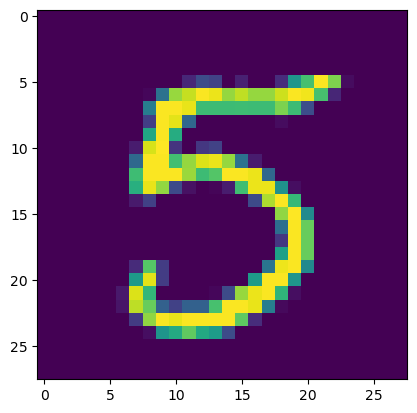

In [9]:
plt.imshow(X.iloc[1].values.reshape(28, 28))

Построим многослойный перцептрон. Оптимизировать будем при помощи SGD, в качестве лосс-функции будем использовать кроссэнтропию, также будем считать accuracy

In [10]:
model = Sequential(
    [
     Dense(32, input_shape=(X.shape[1],), activation='relu'),
     Dense(32, activation='relu'),

     Dense(10, activation='softmax')
    ]
)
model.compile(optimizer=SGD(clipnorm=1), loss=categorical_crossentropy, metrics=[categorical_accuracy])


In [11]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 32)                25120     
                                                                 
 dense_1 (Dense)             (None, 32)                1056      
                                                                 
 dense_2 (Dense)             (None, 10)                330       
                                                                 
Total params: 26506 (103.54 KB)
Trainable params: 26506 (103.54 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [13]:
(28 * 28) * 32 + 32

25120

In [14]:
(32 * 32 + 32)

1056

In [15]:
(32 * 10 + 10)

330

In [16]:
# 28x28 - картинка
#    первый слой         второй слой      выходной слой
((28 * 28) * 32 + 32) + (32 * 32 + 32) + (32 * 10 + 10)

26506

## Гиперпараметры сети

- архитектура сети
- параметры оптимизатора (learning rate и др.)
- регуляризация
- размер батча
- количество эпох

In [17]:
history = model.fit(x_train, y_train, batch_size=10, epochs=10, validation_split=0.1)

Epoch 1/10
1350/1350 [==============================] - 1s 621us/step - loss: 1.1467 - categorical_accuracy: 0.6593 - val_loss: 0.5666 - val_categorical_accuracy: 0.8367
Epoch 2/10
1350/1350 [==============================] - 1s 555us/step - loss: 0.4730 - categorical_accuracy: 0.8627 - val_loss: 0.4025 - val_categorical_accuracy: 0.8827
Epoch 3/10
1350/1350 [==============================] - 1s 550us/step - loss: 0.3839 - categorical_accuracy: 0.8881 - val_loss: 0.3490 - val_categorical_accuracy: 0.9020
Epoch 4/10
1350/1350 [==============================] - 1s 629us/step - loss: 0.3415 - categorical_accuracy: 0.9027 - val_loss: 0.3141 - val_categorical_accuracy: 0.9113
Epoch 5/10
1350/1350 [==============================] - 1s 576us/step - loss: 0.3116 - categorical_accuracy: 0.9107 - val_loss: 0.2976 - val_categorical_accuracy: 0.9187
Epoch 6/10
1350/1350 [==============================] - 1s 576us/step - loss: 0.2920 - categorical_accuracy: 0.9164 - val_loss: 0.2851 - val_categoric

In [18]:
history.history.keys()

dict_keys(['loss', 'categorical_accuracy', 'val_loss', 'val_categorical_accuracy'])

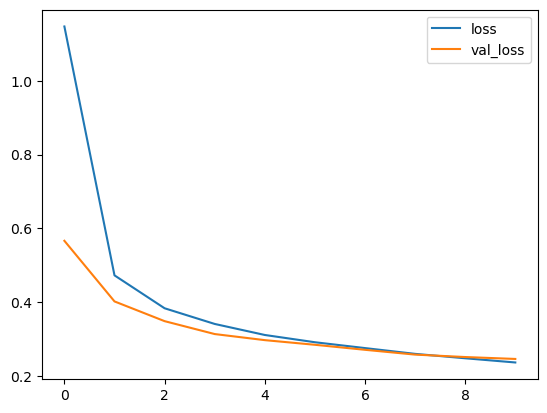

In [19]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
legend_list = ['loss', 'val_loss']
plt.legend(legend_list)

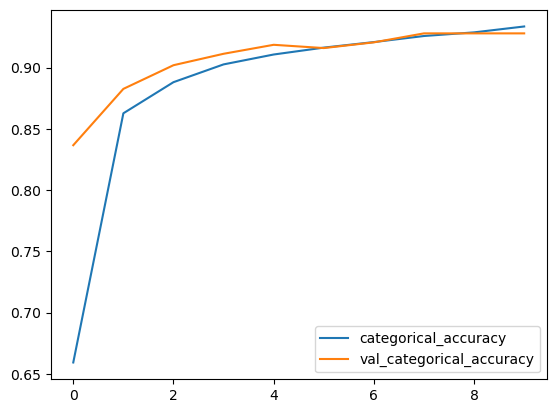

In [20]:
plt.plot(history.history['categorical_accuracy'])
plt.plot(history.history['val_categorical_accuracy'])
plt.legend(['categorical_accuracy', 'val_categorical_accuracy'])

In [21]:
model.evaluate(x_test, y_test)

157/157 [==============================] - 0s 465us/step - loss: 0.3018 - categorical_accuracy: 0.9134


[0.30180370807647705, 0.9133999943733215]

In [22]:
y_pred = model.predict(x_test)
from sklearn.metrics import confusion_matrix
confusion_matrix(y_test.argmax(axis=1), y_pred.argmax(axis=1))

157/157 [==============================] - 0s 415us/step


array([[459,   0,   3,   1,   3,   6,   8,   1,   3,   1],
       [  0, 557,   3,   4,   3,   0,   1,   2,   7,   1],
       [  4,   2, 415,   8,  13,   3,   7,   7,  11,   2],
       [  0,   2,  15, 440,   0,  16,   4,   3,   9,  12],
       [  0,   2,   1,   0, 446,   0,  10,   1,   2,  22],
       [  2,   3,   1,  15,   9, 410,  10,   1,   8,   6],
       [  2,   2,   2,   0,   6,   4, 477,   0,   3,   0],
       [  0,   1,  12,   3,   7,   0,   0, 494,   2,   8],
       [  3,  11,   5,  14,   4,   5,   7,   0, 421,   6],
       [  3,   2,   3,   8,  27,   3,   0,  18,   4, 448]])

Как оценим качество такой модели? Какое качество даст обычная логистическая регрессия?

## Задача

Построить на тех же данных логистическую регрессию, сравнить результаты

In [38]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score

In [39]:
# Ваш код здесь


## Задача

Добавить больше нейронов к существующим слоям, а также добавить новый слой в нейросеть. Измерить качество.

Epoch 1/10
135/135 [==============================] - 0s 2ms/step - loss: 2.1514 - categorical_accuracy: 0.3235 - val_loss: 1.9107 - val_categorical_accuracy: 0.5847
Epoch 2/10
135/135 [==============================] - 0s 2ms/step - loss: 1.5252 - categorical_accuracy: 0.6793 - val_loss: 1.1235 - val_categorical_accuracy: 0.7607
Epoch 3/10
135/135 [==============================] - 0s 2ms/step - loss: 0.8842 - categorical_accuracy: 0.8005 - val_loss: 0.7070 - val_categorical_accuracy: 0.8187
Epoch 4/10
135/135 [==============================] - 0s 2ms/step - loss: 0.6141 - categorical_accuracy: 0.8431 - val_loss: 0.5407 - val_categorical_accuracy: 0.8587
Epoch 5/10
135/135 [==============================] - 0s 2ms/step - loss: 0.4970 - categorical_accuracy: 0.8692 - val_loss: 0.4604 - val_categorical_accuracy: 0.8780
Epoch 6/10
135/135 [==============================] - 0s 2ms/step - loss: 0.4327 - categorical_accuracy: 0.8825 - val_loss: 0.4117 - val_categorical_accuracy: 0.8853
Epoc

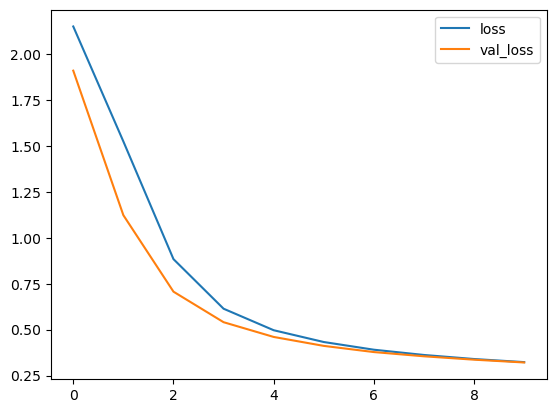

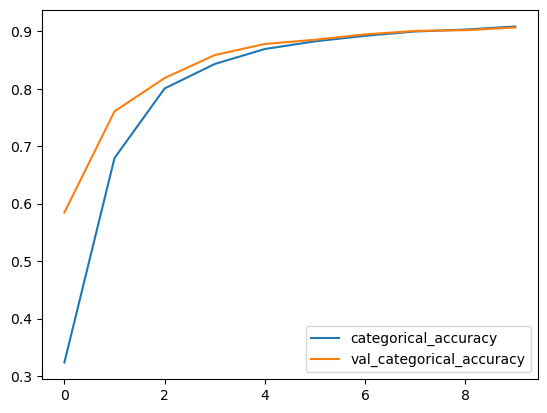

In [25]:
model = Sequential(
    [
     Dense(128, input_shape=(X.shape[1],), activation='relu'),
     Dense(128, activation='relu'),
     Dense(128, activation='relu'),

     Dense(10, activation='softmax')
    ]
)
model.compile(optimizer=SGD(clipnorm=1), loss=categorical_crossentropy, metrics=[categorical_accuracy])

history = model.fit(x_train, y_train, batch_size=100, epochs=10, validation_split=0.1)

plt.figure()
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
legend_list = ['loss', 'val_loss']
plt.legend(legend_list)

plt.figure()
plt.plot(history.history['categorical_accuracy'])
plt.plot(history.history['val_categorical_accuracy'])
plt.legend(['categorical_accuracy', 'val_categorical_accuracy'])

## Задача

Попробовать оптимизатор Adam и RMSprop вместо SGD, сравнить качество (не забываем передавать параметр `clipnorm=1`)

Epoch 1/30
135/135 [==============================] - 1s 3ms/step - loss: 0.5547 - categorical_accuracy: 0.8367 - val_loss: 0.2700 - val_categorical_accuracy: 0.9227
Epoch 2/30
135/135 [==============================] - 0s 2ms/step - loss: 0.2377 - categorical_accuracy: 0.9293 - val_loss: 0.2350 - val_categorical_accuracy: 0.9340
Epoch 3/30
135/135 [==============================] - 0s 2ms/step - loss: 0.1623 - categorical_accuracy: 0.9510 - val_loss: 0.1678 - val_categorical_accuracy: 0.9460
Epoch 4/30
135/135 [==============================] - 0s 2ms/step - loss: 0.1177 - categorical_accuracy: 0.9639 - val_loss: 0.1549 - val_categorical_accuracy: 0.9560
Epoch 5/30
135/135 [==============================] - 0s 2ms/step - loss: 0.0868 - categorical_accuracy: 0.9744 - val_loss: 0.1325 - val_categorical_accuracy: 0.9613
Epoch 6/30
135/135 [==============================] - 0s 2ms/step - loss: 0.0705 - categorical_accuracy: 0.9787 - val_loss: 0.1240 - val_categorical_accuracy: 0.9673
Epoc

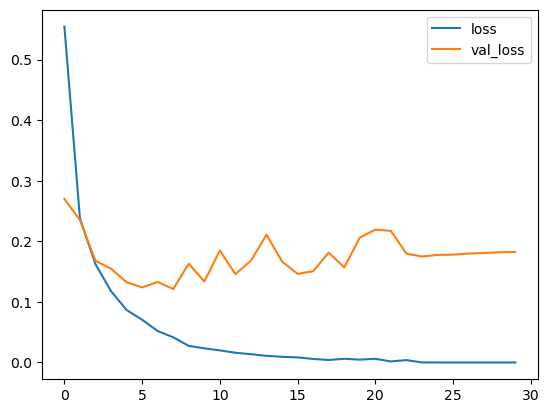

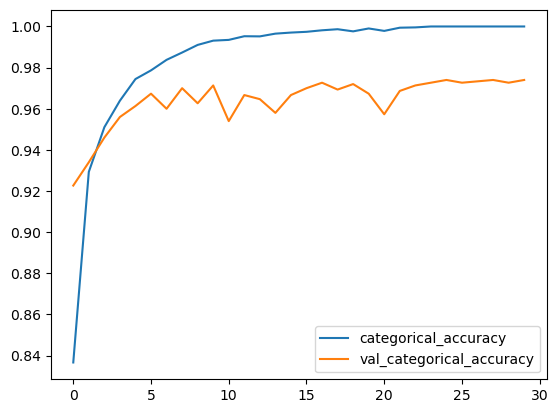

In [28]:
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.optimizers import RMSprop
# Ваш код здесь


model = Sequential(
    [
     Dense(128, input_shape=(X.shape[1],), activation='relu'),
     Dense(128, activation='relu'),
     Dense(128, activation='relu'),

     Dense(10, activation='softmax')
    ]
)
model.compile(optimizer=RMSprop(clipnorm=1), loss=categorical_crossentropy, metrics=[categorical_accuracy])

history = model.fit(x_train, y_train, batch_size=100, epochs=30, validation_split=0.1)

plt.figure()
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
legend_list = ['loss', 'val_loss']
plt.legend(legend_list)

plt.figure()
plt.plot(history.history['categorical_accuracy'])
plt.plot(history.history['val_categorical_accuracy'])
plt.legend(['categorical_accuracy', 'val_categorical_accuracy'])

## Уменьшение learning rate

[Документация по ExponentialDecay](https://keras.io/api/optimizers/learning_rate_schedules/exponential_decay/)

In [40]:
from tensorflow.keras.optimizers.schedules import ExponentialDecay

initial_learning_rate = 0.001
lr_schedule = ExponentialDecay(
    initial_learning_rate,
    decay_steps=100000,
    decay_rate=0.96,
    staircase=True
)

model = Sequential(
    [
     Dense(16, input_shape=(X.shape[1],), activation='sigmoid'),
     Dense(16, activation='relu'),
     Dense(10, activation='softmax')
    ]
)
model.compile(optimizer=Adam(clipnorm=1, learning_rate=lr_schedule), loss=categorical_crossentropy, metrics=[categorical_accuracy])

In [41]:
history = model.fit(x_train, y_train, batch_size=100, epochs=30)

Epoch 1/30
150/150 [==============================] - 0s 1ms/step - loss: 1.8462 - categorical_accuracy: 0.3861
Epoch 2/30
150/150 [==============================] - 0s 843us/step - loss: 0.9909 - categorical_accuracy: 0.7767
Epoch 3/30
150/150 [==============================] - 0s 886us/step - loss: 0.6143 - categorical_accuracy: 0.8535
Epoch 4/30
150/150 [==============================] - 0s 908us/step - loss: 0.4734 - categorical_accuracy: 0.8781
Epoch 5/30
150/150 [==============================] - 0s 766us/step - loss: 0.3994 - categorical_accuracy: 0.8950
Epoch 6/30
150/150 [==============================] - 0s 815us/step - loss: 0.3511 - categorical_accuracy: 0.9045
Epoch 7/30
150/150 [==============================] - 0s 774us/step - loss: 0.3170 - categorical_accuracy: 0.9133
Epoch 8/30
150/150 [==============================] - 0s 770us/step - loss: 0.2908 - categorical_accuracy: 0.9198
Epoch 9/30
150/150 [==============================] - 0s 789us/step - loss: 0.2701 - categ

In [42]:
model.evaluate(x_test, y_test)

157/157 [==============================] - 0s 444us/step - loss: 0.2535 - categorical_accuracy: 0.9260


[0.2534971535205841, 0.9259999990463257]

## Задача

Использовать ExponentialDecay для оптимизатора Adam

In [ ]:
# Ваш код здесь


## Регуляризация

Для того, чтобы избежать переобучения, мы можем использовать регуляризацию. Для линейных моделей мы использовали L1 и L2 регуляризацию. Для нейросетей обычно используют dropout слой.

Интуиция, которая лежит за dropout-слоем состоит в том, что нам не хочется, чтобы модель обучалась по какому-то одному признаку, поэтому мы хотим периодически "отключать" на обучении какие-то связи в слое и смотреть как это влияет на прогноз модели.

Dropout слой ровно это и делает. Мы можем задать вероятность отключения признака и нейросеть присвоит весу этого признака значение 0. Так как при обучении мы много раз проходим через нейросеть, то мы избежим переобучения.

Dropout используется только при обучении, при получении прогноза никакие веса не обнуляются.

При этом обучение будет идти быстрее, но сходиться будет медленнее (потребуется больше эпох, чтобы получить такой же результат)

Чем больше параметров в слое, тем эффективнее будет dropout

## Задача

Применить `Dropout` к полученной выше нейросети к одному из слоев. Сравнить результат.

In [44]:
Dropout(0.25)

In [45]:
# Ваш код здесь
model = Sequential(
    [
     Dense(32, input_shape=(X.shape[1],), activation='relu'),
     Dense(32, activation='relu'),
     Dropout(0.5),
     Dense(10, activation='softmax')
    ]
)
model.compile(optimizer=Adam(clipnorm=1), loss=categorical_crossentropy, metrics=[categorical_accuracy])

In [46]:
history = model.fit(x_train, y_train, batch_size=128, epochs=25, validation_split=0.1)

Epoch 1/25
106/106 [==============================] - 0s 1ms/step - loss: 1.6062 - categorical_accuracy: 0.4481 - val_loss: 0.7588 - val_categorical_accuracy: 0.8327
Epoch 2/25
106/106 [==============================] - 0s 969us/step - loss: 0.8917 - categorical_accuracy: 0.7112 - val_loss: 0.4670 - val_categorical_accuracy: 0.8920
Epoch 3/25
106/106 [==============================] - 0s 1ms/step - loss: 0.6994 - categorical_accuracy: 0.7798 - val_loss: 0.3692 - val_categorical_accuracy: 0.9033
Epoch 4/25
106/106 [==============================] - 0s 996us/step - loss: 0.5866 - categorical_accuracy: 0.8190 - val_loss: 0.3322 - val_categorical_accuracy: 0.9113
Epoch 5/25
106/106 [==============================] - 0s 950us/step - loss: 0.5283 - categorical_accuracy: 0.8396 - val_loss: 0.2966 - val_categorical_accuracy: 0.9233
Epoch 6/25
106/106 [==============================] - 0s 986us/step - loss: 0.4771 - categorical_accuracy: 0.8541 - val_loss: 0.2824 - val_categorical_accuracy: 0.9

In [47]:
model.evaluate(x_test, y_test)

157/157 [==============================] - 0s 424us/step - loss: 0.2294 - categorical_accuracy: 0.9380


[0.22943173348903656, 0.9380000233650208]

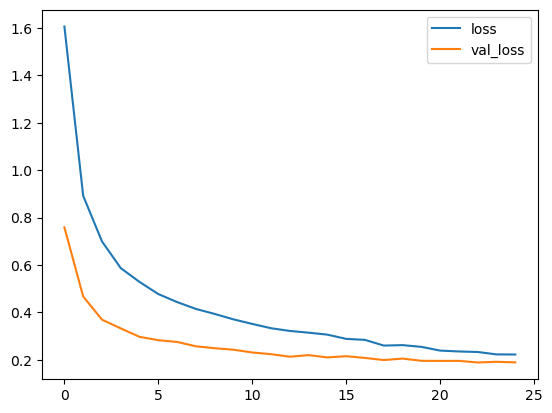

In [48]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
legend_list = ['loss', 'val_loss']
plt.legend(legend_list)

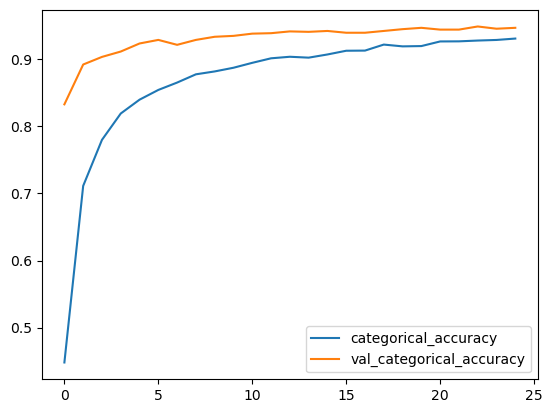

In [49]:
plt.plot(history.history['categorical_accuracy'])
plt.plot(history.history['val_categorical_accuracy'])
plt.legend(['categorical_accuracy', 'val_categorical_accuracy'])

## Сверточные нейронные сети

Обучая многослойный перцептрон можно аппроксимировать любую функцию, но для некоторых задач проще использовать другую архитектуру сети. Например, для задач с аудио и картинками хорошо подходит сверточная нейронная сеть (CNN).

![pic](../images/conv_nn.png)

Сверточная нейронная сеть состоит, как правило, из двух слоев - свертка и пулинг.

Свертка получается, когда по исходному изображению проходит скользящее окно в виде квадратной матрицы. На каждом шаге происходит покомпонентное умножение матриц (исходного изображения и ядра - квадратной матрицы). Дальше результат суммируется и записывается в новую матрицу. После чего вся новая матрица проходит через функцию активации (обычно relu).

После свертки применяется пулинг. Матрица делится на квадратики (пулы), и в каждом квадратике выбирается наибольшее значение.

![pic](../images/convolution+relu.png)

Во время обучения подбираются коэфициенты ядра. Как правило, на каждом слое обучают несколько фильтров.

In [44]:
import numpy as np
from tensorflow import keras
from tensorflow.keras import layers

Приводим изображения к размерности (28, 28, 1), потому что картинка черно-белая 28х28

In [45]:
X_images = X.values.reshape(-1, 28, 28, 1)
x_train, x_test, y_train, y_test = train_test_split(X_images, y)
x_train.shape

(15000, 28, 28, 1)

In [46]:
model = Sequential(
    [
        keras.Input(shape=(28, 28, 1)),
        layers.Conv2D(64, kernel_size=(3, 3), activation="relu"),
        layers.MaxPooling2D(pool_size=(2, 2)),
        layers.Conv2D(64, kernel_size=(3, 3), activation="relu"),
        layers.MaxPooling2D(pool_size=(2, 2)),
        layers.Conv2D(64, kernel_size=(3, 3), activation="relu"),
        layers.MaxPooling2D(pool_size=(2, 2)),
        layers.Flatten(),
        layers.Dense(10, activation="softmax"),
    ]
)

batch_size = 128
epochs = 5

model.compile(loss="categorical_crossentropy", optimizer="adam", metrics=["accuracy"])

In [49]:
(13 * 13 * 64) * 3

32448

In [47]:
model.summary()

Model: "sequential_12"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 26, 26, 64)        640       
                                                                 
 max_pooling2d (MaxPooling2  (None, 13, 13, 64)        0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 11, 11, 64)        36928     
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 5, 5, 64)          0         
 g2D)                                                            
                                                                 
 conv2d_2 (Conv2D)           (None, 3, 3, 64)          36928     
                                                                 
 max_pooling2d_2 (MaxPoolin  (None, 1, 1, 64)        

In [50]:
history = model.fit(x_train, y_train, batch_size=batch_size, epochs=20, validation_split=0.1)

Epoch 1/20
106/106 [==============================] - 4s 34ms/step - loss: 0.7554 - accuracy: 0.7838 - val_loss: 0.3024 - val_accuracy: 0.9133
Epoch 2/20
106/106 [==============================] - 3s 33ms/step - loss: 0.2002 - accuracy: 0.9385 - val_loss: 0.2008 - val_accuracy: 0.9413
Epoch 3/20
106/106 [==============================] - 3s 33ms/step - loss: 0.1452 - accuracy: 0.9561 - val_loss: 0.1678 - val_accuracy: 0.9507
Epoch 4/20
106/106 [==============================] - 3s 33ms/step - loss: 0.1161 - accuracy: 0.9633 - val_loss: 0.1329 - val_accuracy: 0.9580
Epoch 5/20
106/106 [==============================] - 4s 34ms/step - loss: 0.0875 - accuracy: 0.9743 - val_loss: 0.1232 - val_accuracy: 0.9653
Epoch 6/20
106/106 [==============================] - 4s 34ms/step - loss: 0.0725 - accuracy: 0.9781 - val_loss: 0.1188 - val_accuracy: 0.9667
Epoch 7/20
106/106 [==============================] - 4s 34ms/step - loss: 0.0640 - accuracy: 0.9804 - val_loss: 0.1006 - val_accuracy: 0.9693

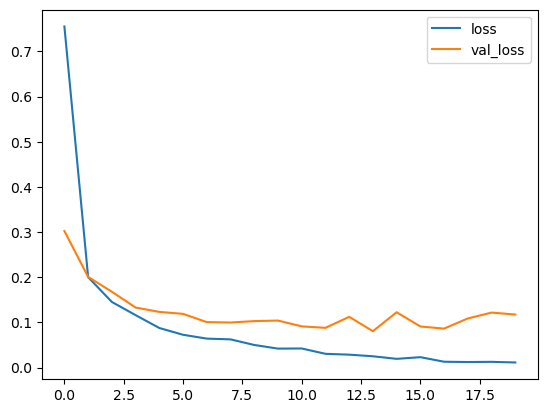

In [51]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.legend(['loss', 'val_loss'])

In [52]:
model.evaluate(x_test, y_test)

157/157 [==============================] - 1s 5ms/step - loss: 0.1155 - accuracy: 0.9706


[0.11551973968744278, 0.9706000089645386]

In [53]:
y_pred = model.predict(x_test)
from sklearn.metrics import confusion_matrix
confusion_matrix(y_test.argmax(axis=1), y_pred.argmax(axis=1))

157/157 [==============================] - 1s 5ms/step


array([[482,   0,   1,   1,   0,   0,   1,   0,   2,   0],
       [  0, 533,   4,   0,   4,   0,   0,   1,   0,   0],
       [  0,   0, 469,   8,   3,   0,   0,   3,   1,   0],
       [  1,   1,   4, 541,   0,   1,   0,   3,   0,   3],
       [  0,   0,   0,   0, 470,   0,   0,   0,   0,   4],
       [  2,   0,   0,   4,   2, 406,   1,   0,   5,   1],
       [  5,   0,   0,   0,   4,   2, 517,   0,   4,   0],
       [  3,   3,  11,  12,   2,   0,   0, 474,   0,  19],
       [  1,   0,   0,   2,   2,   0,   0,   0, 446,   5],
       [  4,   0,   0,   1,   5,   0,   0,   1,   0, 515]])

In [56]:
idx = y_test.argmax(axis=1) != y_pred.argmax(axis=1)
x_wrong = x_test[idx]
y_pred_wrong = y_pred.argmax(axis=1)[idx]
y_test_wrong = y_test.argmax(axis=1)[idx]


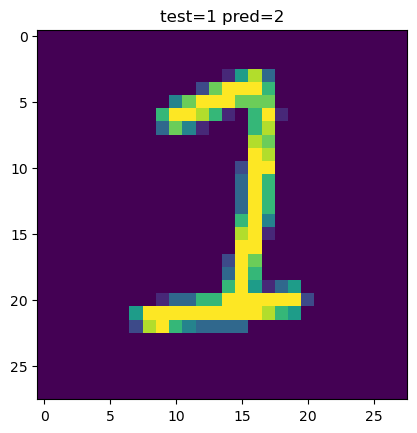

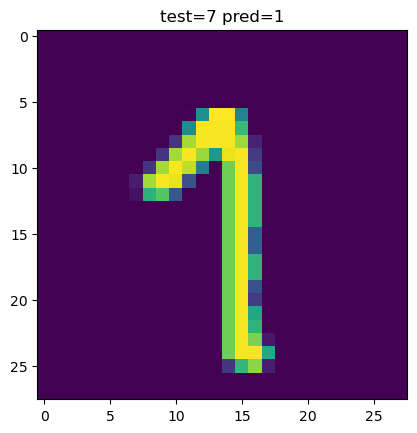

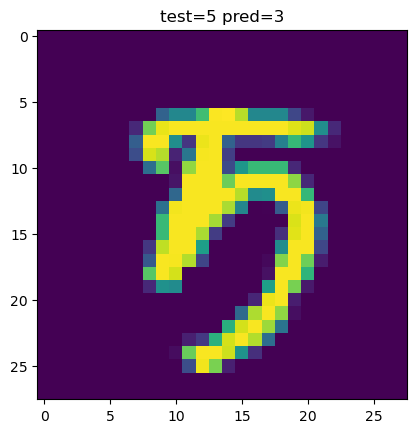

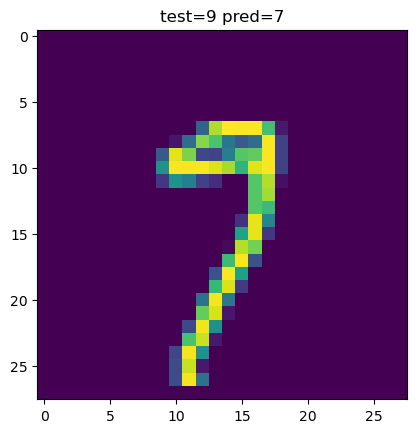

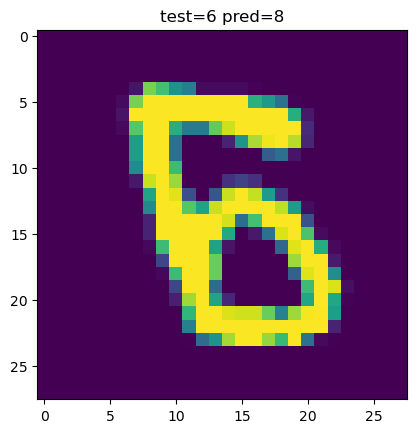

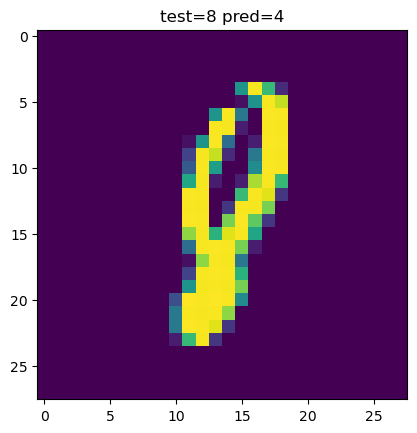

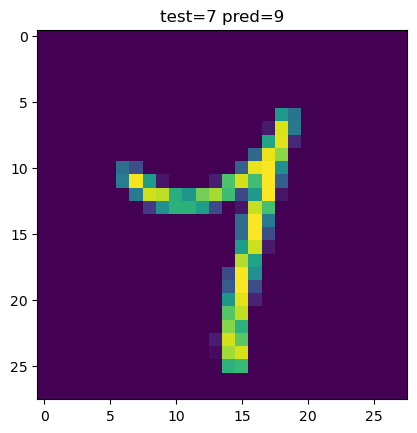

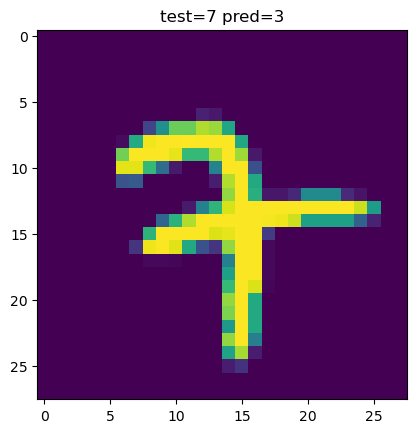

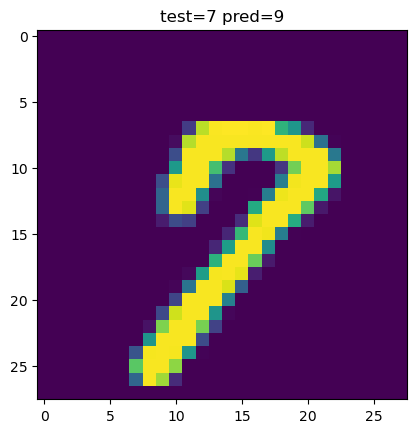

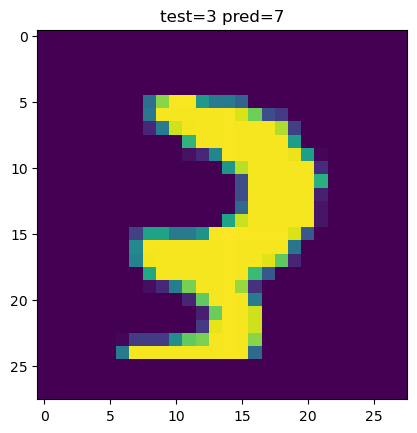

In [58]:
for i in range(10):
    plt.figure()
    plt.imshow(x_wrong[i, :, :, :])
    plt.title(f"test={y_test_wrong[i]} pred={y_pred_wrong[i]}")

In [55]:
y_test.shape, y_pred_wrong.shape

((5000, 10), (147,))

## Задача

Взять данные с Kaggle по датасету [Fashion MNIST](https://www.kaggle.com/zalando-research/fashionmnist?select=fashion-mnist_train.csv).

В датасете представлены картинки одежды, нужно построить классификатор, который определит, что находится на картинке.

Обучить на этих данных сверточную нейронную сеть. Можно использовать архитектуру из примера выше, можно ее усложнить.

Оценить качество модели.

In [60]:
df = pd.read_csv('../data/fashion_mnist/fashion-mnist_train.csv')
df.head()



,label,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,pixel9,...,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783,pixel784
0,2,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,9,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,6,0,0,0,0,0,0,0,5,0,...,0,0,0,30,43,0,0,0,0,0
3,0,0,0,0,1,2,0,0,0,0,...,3,0,0,0,0,1,0,0,0,0
4,3,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [ ]:
! unzip fashion-mnist_train.csv.zip

In [ ]:
# Ваш код здесь
{
  0: 'T-shirt/top',
  1: 'Trouser',
  2: 'Pullover',
  3: 'Dress',
  4: 'Coat',
  5: 'Sandal',
  6: 'Shirt',
  7: 'Sneaker',
  8: 'Bag',
  9: 'Ankle boot',
}

## Задача

По этим же данным построить модель логистической регрессии. Сравнить результаты.

In [ ]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score

## Полезные ссылки

- [Учебник ШАДа по сверточным сетям](https://education.yandex.ru/handbook/ml/article/svyortochnye-nejroseti)
- [Как сверточные сети видят мир](https://blog.keras.io/how-convolutional-neural-networks-see-the-world.html)
- [Еще про сверточные сети](https://habr.com/ru/post/348000/)
- [Исследование про интерпретацию картиночных сеток](https://distill.pub/2020/circuits/zoom-in/)